fun trick to get imports to work properly

In [944]:
import sys
sys.path.insert(0, '..')

In [945]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import numpy

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *

# the real world
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astrocut import fits_cut
from astropy.nddata import Cutout2D

import pandas as pd

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

data loading

In [946]:
ddir = '../data/MAST_2024-07-03T0023-1/'

fname = ddir + 'HST/n9nk01010/n9nk01010_mos.fits'
#fname = ddir + 'HST/n8yj02010/n8yj02010_mos.fits'
#fname = ddir + 'HST/n9nk14010/n9nk14010_mos.fits'

#fname = ddir + 'HST/n9nk01020/n9nk01020_mos.fits'
#fname = ddir + 'HST/n9nk14020/n9nk14020_mos.fits'
#fname = ddir + 'HST/n8yj65020/n8yj65020_mos.fits'


#dir = '../data/MAST_2024-07-07T03_17_36.223Z/'
#fname = ddir + 'HST/n8ku01050_mos.fits'

ddir = '../data/MAST_2024-07-11T09_26_05.575Z/'
fname = ddir + 'HST/N43CA5020/n43ca5020_mos.fits'

data = fits.getdata(fname, ext=1)
err = fits.getdata(fname, ext=2)
info = fits.getdata(fname, ext=3)

image_hdr = fits.getheader(fname, ext=1) # this is the header for just the image in particular

# rather than manipulate WCS coordinates ourselves, can use https://docs.astropy.org/en/stable/wcs/
w = WCS(image_hdr)

y,x = numpy.unravel_index(numpy.argmax(data),data.shape)
centre = SkyCoord(w.pixel_to_world(x,y), unit='deg') # astropy wants to keep track of units

wid = 64

# use fits_cut because we want WCS metadata cropped appropriately
#cuts = fits_cut(fname, centre, 64, single_outfile=True, memory_only=True)
#cutout = cuts[0]
#cropped = cutout[1].data
#cropped_image_hdr = cutout[1].header



cropped = Cutout2D(data, centre, wid, wcs=w).data
err_cropped = Cutout2D(err, centre, wid, wcs=w).data
info_cropped = Cutout2D(info, centre, wid, wcs=w).data

cropped_data = np.asarray(cropped, dtype=float)#+0.1#.clip(min=0)
cropped_err = np.asarray(err_cropped, dtype=float)

bad_pix = cropped_err==0.0

off = wid//2 - 5

"""bad_pix = bad_pix.at[3+off,1+off].set(True)
bad_pix = bad_pix.at[5+off,1+off].set(True)
bad_pix = bad_pix.at[5+off,5+off].set(True)
bad_pix = bad_pix.at[3+off,8+off].set(True)
bad_pix = bad_pix.at[7+off,6+off].set(True)
bad_pix = bad_pix.at[8+off,4+off].set(True)
bad_pix = bad_pix.at[7+off,4+off].set(True)

bad_pix = bad_pix.at[7+off,7+off].set(True)

#bad_pix = bad_pix.at[80,77].set(True)

"""

X, Y = np.meshgrid(np.arange(wid),np.arange(wid))
middle = wid//2

#bad_pix = bad_pix.at[(X > middle-2)&(X< middle+2)&(Y > middle-2)&(Y < middle+2)].set(True)


bad_pix_2 = (info_cropped&256) | (info_cropped&64) | (info_cropped&32)

cropped_err = np.where(bad_pix | bad_pix_2, np.nan,cropped_err)
cropped_data = np.where(bad_pix | bad_pix_2 , np.nan, cropped_data)

f170m = np.asarray(pd.read_csv("../data/HST_NICMOS1.F170M.dat", sep=' '))
f095n = np.asarray(pd.read_csv("../data/HST_NICMOS1.F095N.dat", sep=' '))
f145m = np.asarray(pd.read_csv("../data/HST_NICMOS1.F145M.dat", sep=' '))


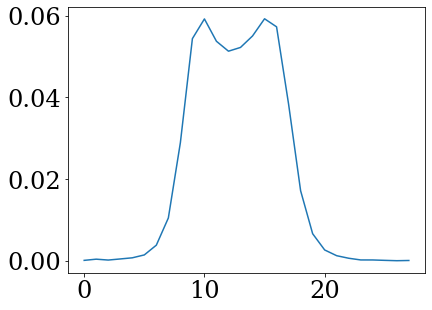

In [947]:
plt.plot(f095n[::5,1])

In [948]:
data[0,0]/err[0,0]

/var/folders/hv/659ls99s2sjd7m3dfr17k8cm0000gn/T/ipykernel_2934/1814355406.py:1: RuntimeWarning: invalid value encountered in scalar divide
  data[0,0]/err[0,0]


np.float32(nan)

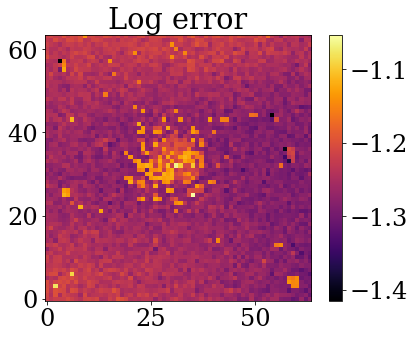

In [949]:
plt.imshow(np.log10(cropped_err))
plt.title("Log error")
plt.colorbar()

construct model

In [950]:
# F170M

#wavels = 1e-6 * np.linspace(1.60, 1.80, 20)

# F110W
#wavels = 1e-6 * np.linspace(0.8, 1.35, 40)

#weights = np.concatenate([np.linspace(0., 1., 10), np.linspace(1., 0., 10)])

#wavels = f170m[::25,0]/1e10
#weights = f170m[::25,1]

wavels = f095n[::5,0]/1e10
weights = f095n[::5,1]


temp = 3210 #check this

c=3e8
h = 6.626e-34
kb = 1.38e-23

f = c/wavels

# blackbody calculation
B = 2*h*c/(wavels**3) * 1/(np.exp(h*f/(kb*temp))-1)

b_weights = weights*B/np.max(B)

source = dl.PointSource(
    #wavelengths=wavels,
    spectrum=dl.Spectrum(wavels, weights),
    flux = 5000,
    position = np.asarray([-5e-7,5e-7])
)

source = dl.BinarySource(
    #position = np.asarray([-5e-7,5e-7]),
    wavelengths=wavels,
    weights=weights,
    spectrum=dl.Spectrum(wavels, weights),
    mean_flux=5000,
    separation=dlu.arcsec2rad(0.042),
    #position_angle=7*np.pi/4,
    #contrast = 0.3,
)

oversample = 3

optics = dl.AngularOpticalSystem(
    512,
    2.4,
    [
        dl.CompoundAperture([
            ("main_aperture",HSTMainAperture(transformation=dl.CoordTransform(rotation=np.pi/4),softening=0.1)),
            ("cold_mask",NICMOSColdMask(transformation=dl.CoordTransform(translation=np.asarray((-0.05,-0.05)),rotation=np.pi/4), softening=0.1))
        ],normalise=True),
        dl.AberratedAperture(
            dl.layers.CircularAperture(1.2),
            noll_inds=np.asarray([4,5,6,7,8,9,10,11]),#,12,13,14,15,16,17,18,19,20]),
            coefficients = np.asarray([0,18,19.4,-1.4,-3,3.3,1.7,-12.2])*1e-9#,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])*1e-9
        )
    ],
    wid,
    0.0432,
    oversample
)

detector = dl.LayeredDetector(
    [
        ("detector_response", ApplyNonlinearity(coefficients=np.zeros(1), order = 3)),
        ("constant", dl.layers.AddConstant(value=0.0)),
        ("pixel_response",dl.layers.ApplyPixelResponse(np.ones((wid*oversample,wid*oversample)))),
        #("jitter", dl.layers.ApplyJitter(sigma=0.1)),
        ("downsample", dl.layers.Downsample(oversample))
     ]
)


telescope = dl.Telescope(
    optics,
    source,
    detector
)

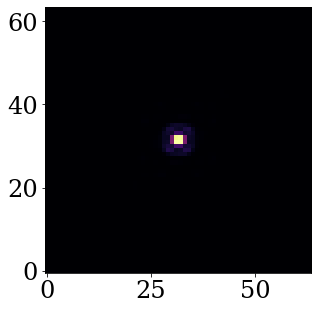

In [951]:
plt.imshow(telescope.model())

gradient time

In [952]:

# need a better name for this

opt = lambda x: optax.sgd(x, nesterov=True, momentum=0.6)

def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]

things = {
    "mean_flux" : opt(3e-3),
    "position": opt(1e-23),
    "separation": opt(1e-22),
    "contrast": opt(1e-8),
    "position_angle": opt(3e-10),
    "cold_mask.transformation.translation": opt(1e-13),
    "cold_mask.transformation.rotation": opt(1e-12),
    "AberratedAperture.coefficients": opt(0.5e-23),
    (
        "cold_mask.outer.radius",
        "cold_mask.secondary.radius"
    ) : opt(5e-13),
    "cold_mask.spider.width": opt(1e-13),
    #"main_aperture.spider.width": opt(0e-3),
    #"cold_mask.softening" : opt(0e-3),
    "constant.value" : opt(1e-9),
    #"detector_response.coefficients" : opt(0e-10),
    #"optics.psf_pixel_scale" : opt(0e-10),

}

groups = list(things.keys())
paths = flatten(groups)
optimisers = [things[i] for i in groups]
groups = [list(x) if isinstance(x, tuple) else x for x in groups]

In [953]:
@zdx.filter_jit
@zdx.filter_value_and_grad(paths)
def loss_fn(model,data):
    img, err, bad = data
    psf = model.model()
    img = np.where(bad, psf, img)
    err = np.where(bad, 1e10, err)
    return -np.where(bad, 0., jsp.stats.norm.logpdf(psf, img, err)).sum()

le optimisation

In [954]:
pixel_opt = optax.piecewise_constant_schedule(init_value=1e-4*1e-8, 
                             boundaries_and_scales={100 : int(1e8)})


optim, opt_state = zdx.get_optimiser(
    telescope, groups, optimisers
)

losses, models = [], []
for i in tqdm(range(100)):
    loss, grads = loss_fn(telescope,(cropped_data,cropped_err, bad_pix))
    updates, opt_state = optim.update(grads, opt_state)
    telescope = zdx.apply_updates(telescope, updates)

    models.append(telescope)
    losses.append(loss)


  0%|          | 0/100 [00:00<?, ?it/s]

1.113555e+08, 5.817518e+05
mean_flux 3222.0662
position [-5.5032703e-09  9.3084672e-08]
separation 1.7622492e-07
contrast 0.14946157
position_angle 1.7119243
cold_mask.transformation.translation [-0.05016804 -0.04998255]
cold_mask.transformation.rotation 0.7838525
AberratedAperture.coefficients [ 4.8363280e-10  4.4253614e-08  1.1983323e-08 -3.3662999e-08
  1.6688862e-08  1.2659662e-08 -1.0760737e-09 -2.6857370e-09]
cold_mask.outer.radius 1.1444601
cold_mask.secondary.radius 0.4475845
cold_mask.spider.width 0.09251691
constant.value 0.0020173492


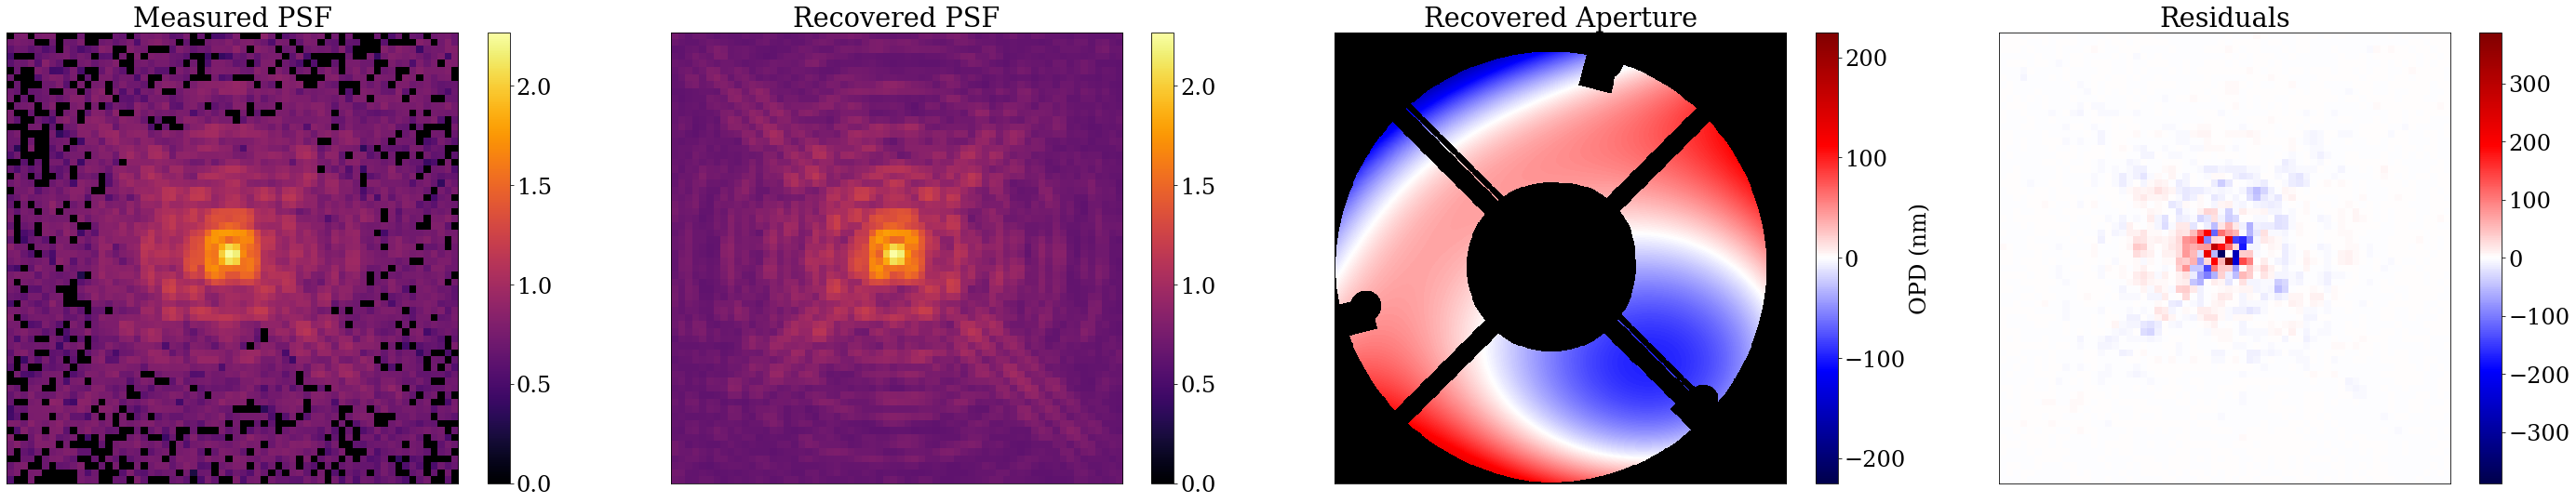

In [955]:
print(f"{float(losses[0]):e}, {float(losses[-1]):e}")

#print(telescope.get(paths))

for g in groups:
    if type(g) == list:
        for s in g:
            print(s, telescope.get(s))
    else:
        print(g, telescope.get(g))

#plt.figure(figsize=(10, 4))


fig, axs = plt.subplots(1,4, figsize=(40,8))

fig.tight_layout()

cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)

#vm = max(np.max(cropped_data),np.max(telescope.model()))

coords = dlu.pixel_coords(512, 2.4)
cropped_frame = cropped_data**0.125
telescope_frame = telescope.model()**0.125

vm = max(np.nanmax(cropped_frame),np.nanmax(telescope_frame))
cd=axs[0].imshow(cropped_frame, vmin=0,vmax=vm,cmap=cmap)
plt.colorbar(cd,ax=axs[0])
tl=axs[1].imshow(telescope_frame, vmin=0, vmax=vm,cmap=cmap)
plt.colorbar(tl,ax=axs[1])
#axs[2].imshow(cropped_err)
cmap = matplotlib.colormaps['seismic']
cmap.set_bad('k',1)
support = telescope.optics.transmission(coords,2.4/512)
support_mask = support.at[support < .5].set(np.nan)

opd = telescope.optics.AberratedAperture.eval_basis(coords)*1e9
olim = np.max(np.abs(opd))
apt =axs[2].imshow(support_mask*opd,cmap=cmap,vmin=-olim, vmax=olim)
plt.colorbar(apt, ax=axs[2]).set_label("OPD (nm)")
#axs[4].imshow(telescope.detector.pixel_response.pixel_response)
resid = (cropped_data - telescope.model())/cropped_err
rlim = np.nanmax(np.abs(resid))
resid=axs[3].imshow(resid, cmap='seismic',vmin=-rlim, vmax=rlim)
plt.colorbar(resid,ax=axs[3])

axs[0].set_title("Measured PSF")
axs[1].set_title("Recovered PSF")
axs[2].set_title("Recovered Aperture")
axs[3].set_title("Residuals")

for i in range(4):
    axs[i].set_xticks([])
    axs[i].set_yticks([])

#axs[1].imshow(telescope.optics.aberrations.eval_basis(coords)*1e9)
plt.show()
#plt.imshow(np.abs(telescope.model()-cropped_data)**0.25)


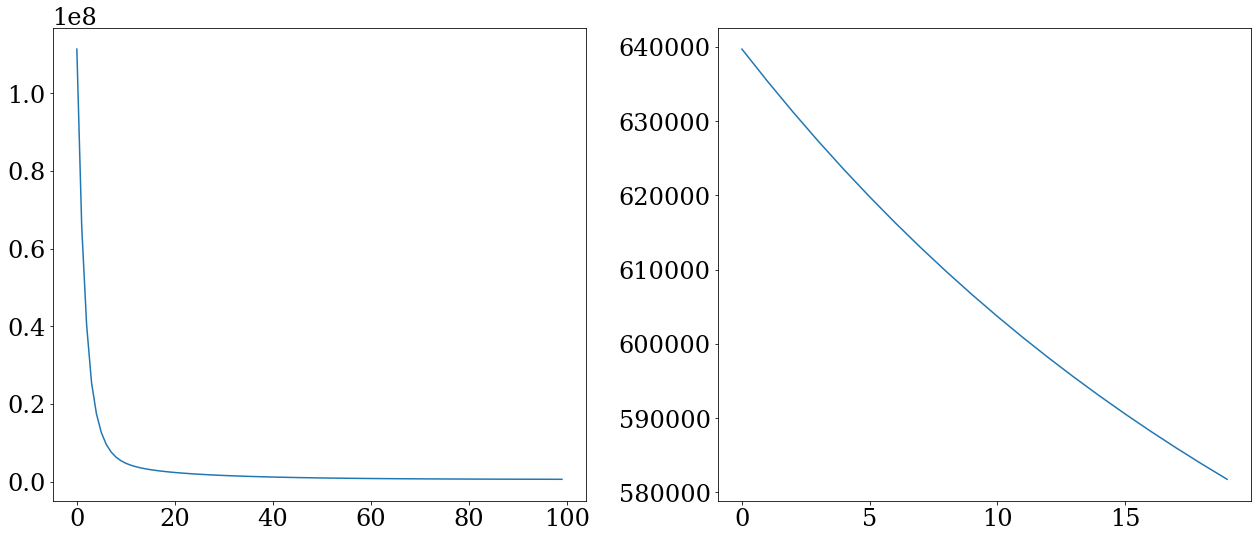

In [956]:
fig, axs = plt.subplots(1,2, figsize=(18,8))
axs[0].plot(losses)
axs[1].plot(losses[-20:])
fig.tight_layout()

11
mean_flux
position
separation
contrast
position_angle
cold_mask.transformation.translation
cold_mask.transformation.rotation
AberratedAperture.coefficients
['cold_mask.outer.radius', 'cold_mask.secondary.radius']
cold_mask.spider.width
constant.value


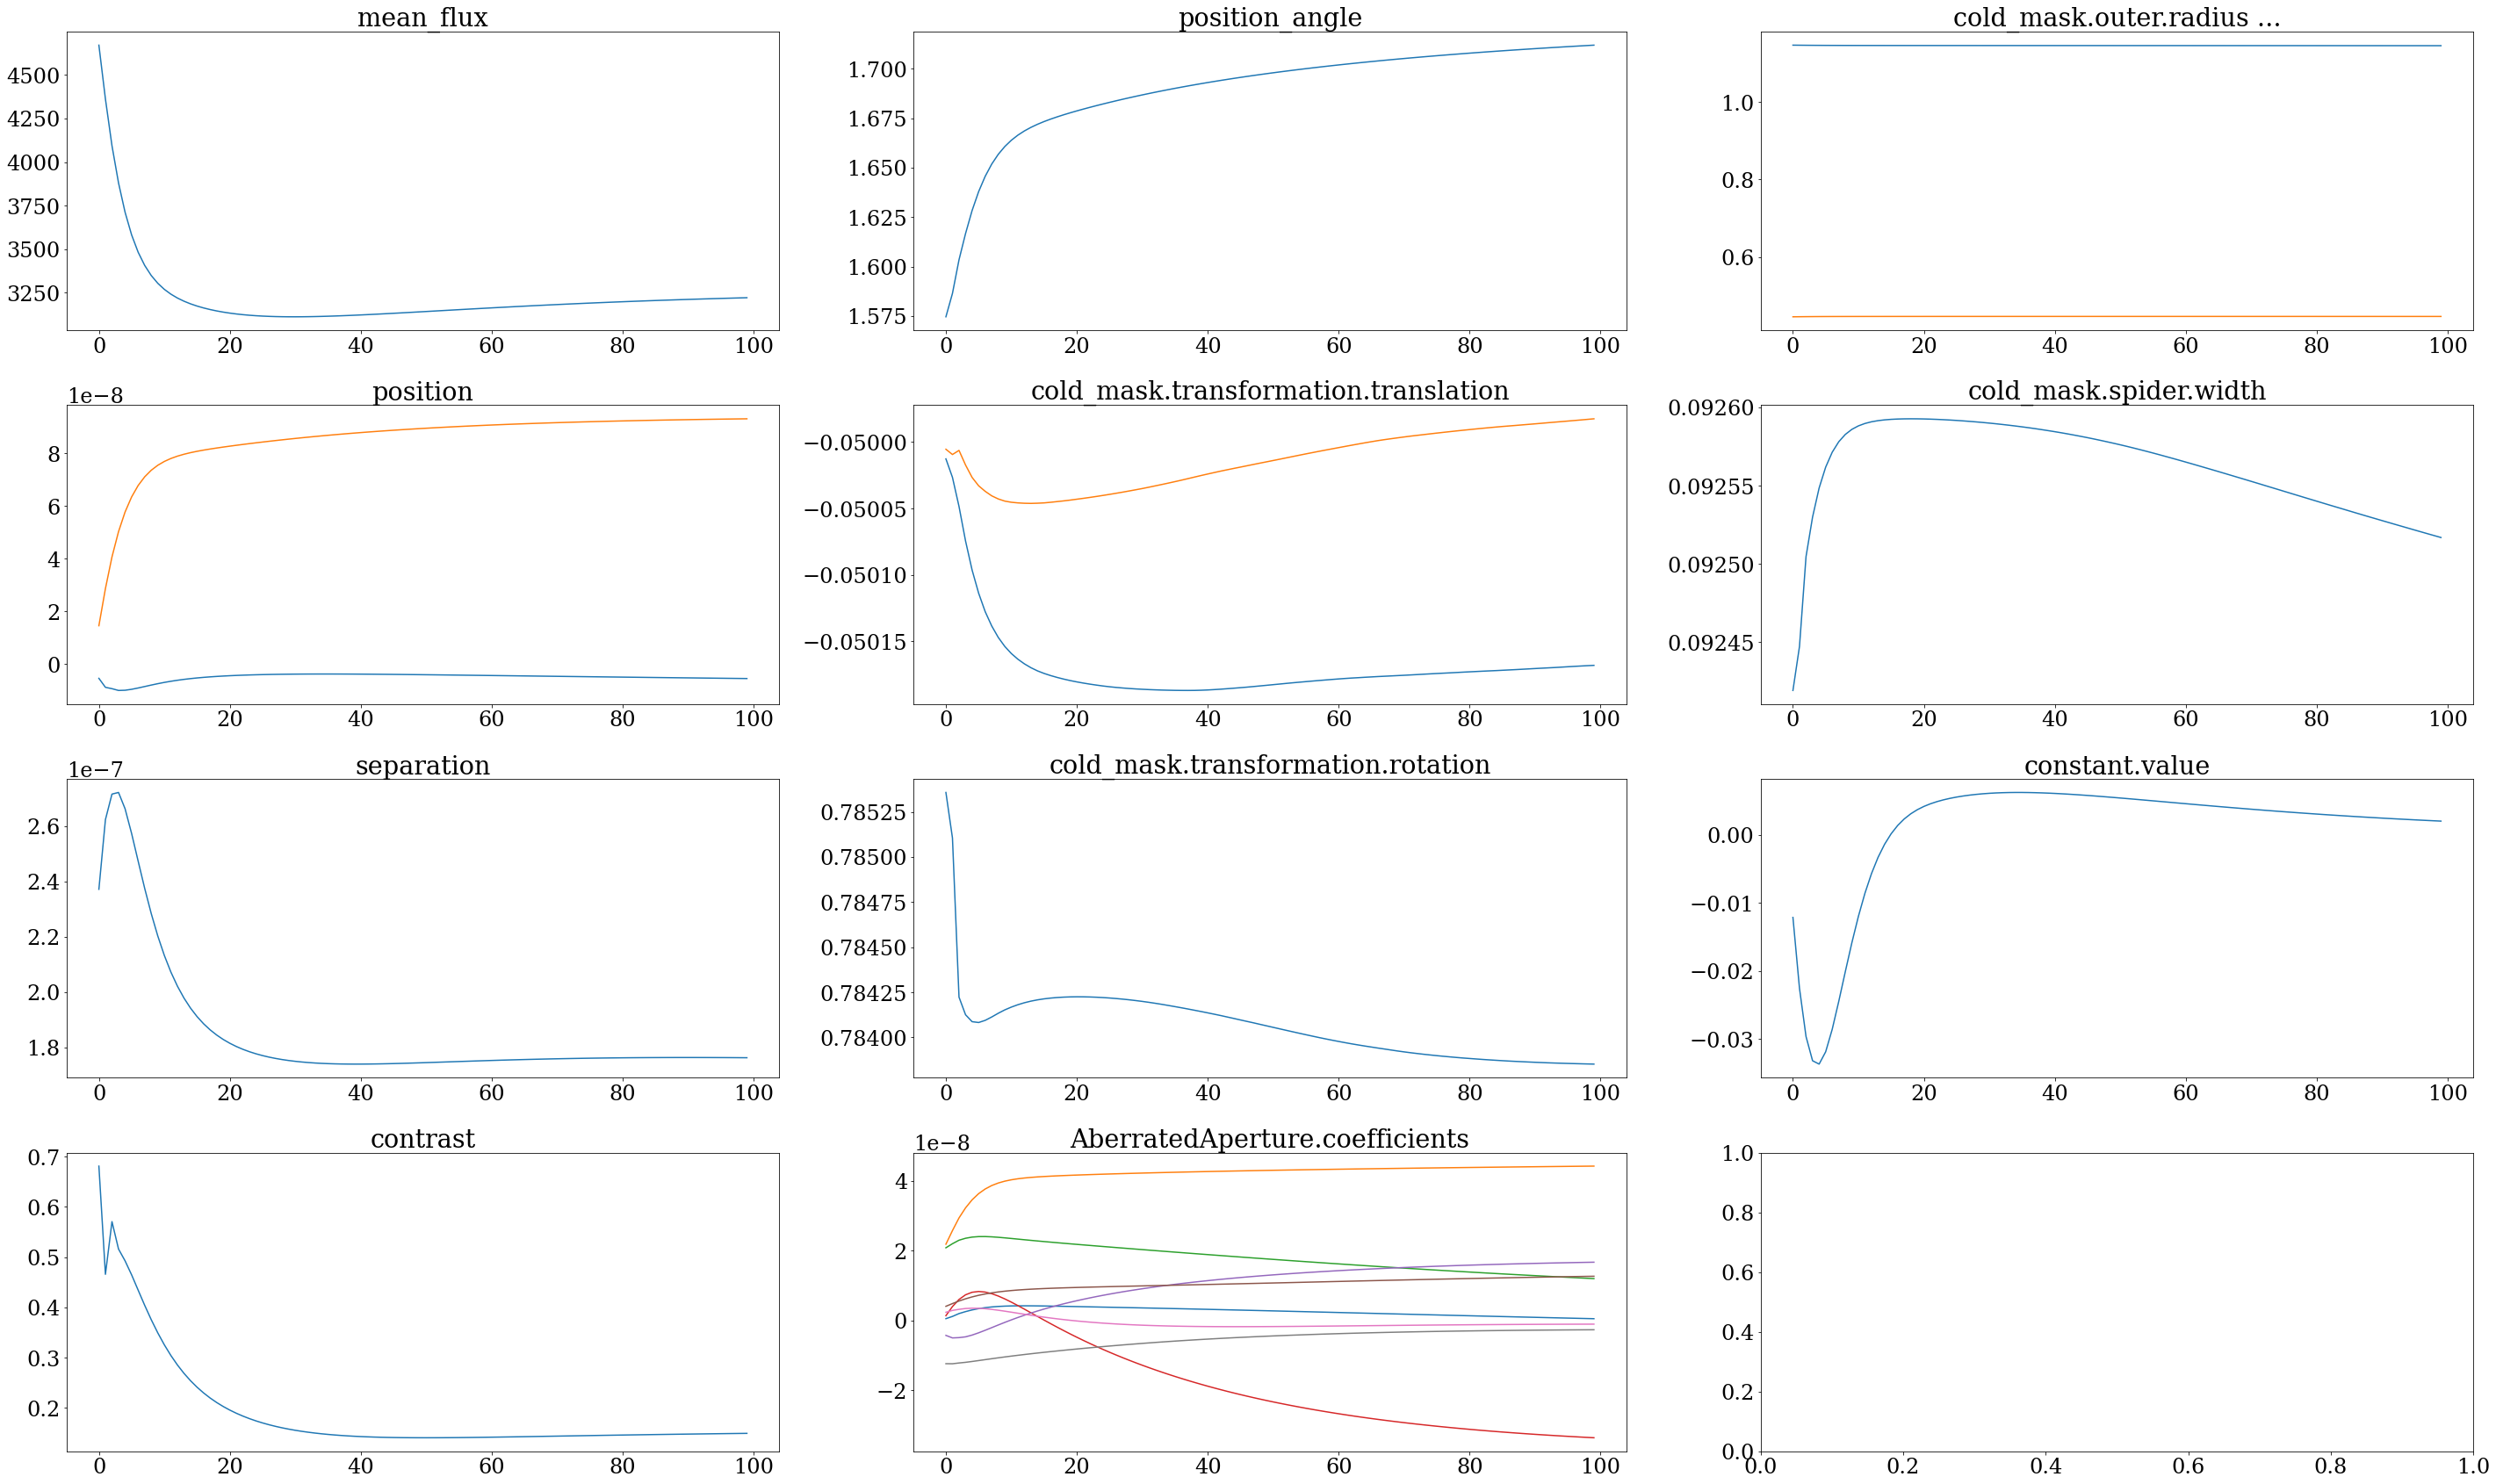

In [957]:
#plt.plot([x.get("cold_mask.transformation.translation")[0] for x in models])

xw = 4
yw = int(np.ceil(len(groups)/xw))

print(len(groups))

fig, axs = plt.subplots(xw,yw,figsize=(xw*10,yw*8))
for i, param in enumerate(groups):
    print(param)
    sp = axs[i%xw, i//xw]
    if type(param) == list:
        sp.set_title(f"{param[0]} ...")
        for p in param:
            sp.plot([x.get(p) for x in models])
    else:
        sp.set_title(param)
        sp.plot([x.get(param) for x in models])
    
fig.tight_layout()

(Array(31, dtype=int32), Array(32, dtype=int32))

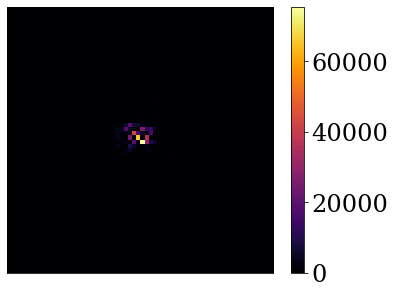

In [958]:
cmap = matplotlib.colormaps['inferno']
#cmap.set_bad('k',1)
lpdf = -jsp.stats.norm.logpdf(telescope.model(), cropped_data, cropped_err)
plt.imshow(lpdf, cmap)
plt.colorbar()
plt.xticks([])
plt.yticks([])
np.unravel_index(np.nanargmax(lpdf),lpdf.shape)